<a href="https://colab.research.google.com/github/jiyanshud22/MTH422_Project_Team13/blob/main/MTH422_Project_code_4_2_section.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

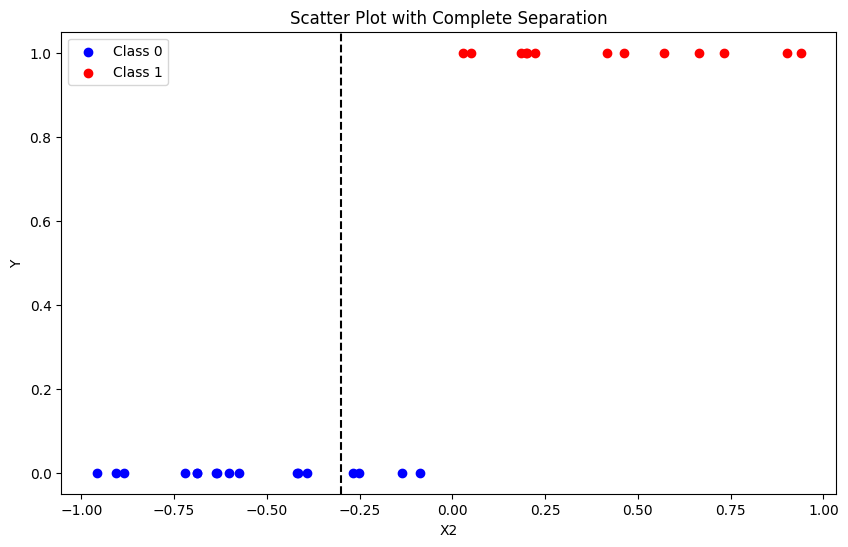

Output()

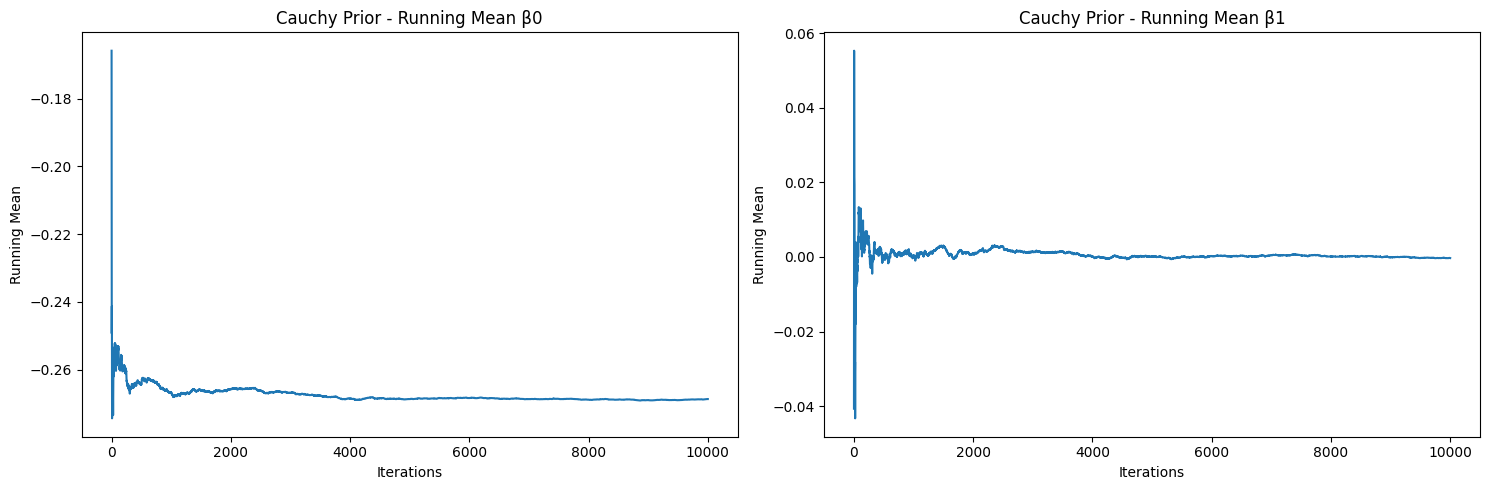

Output()

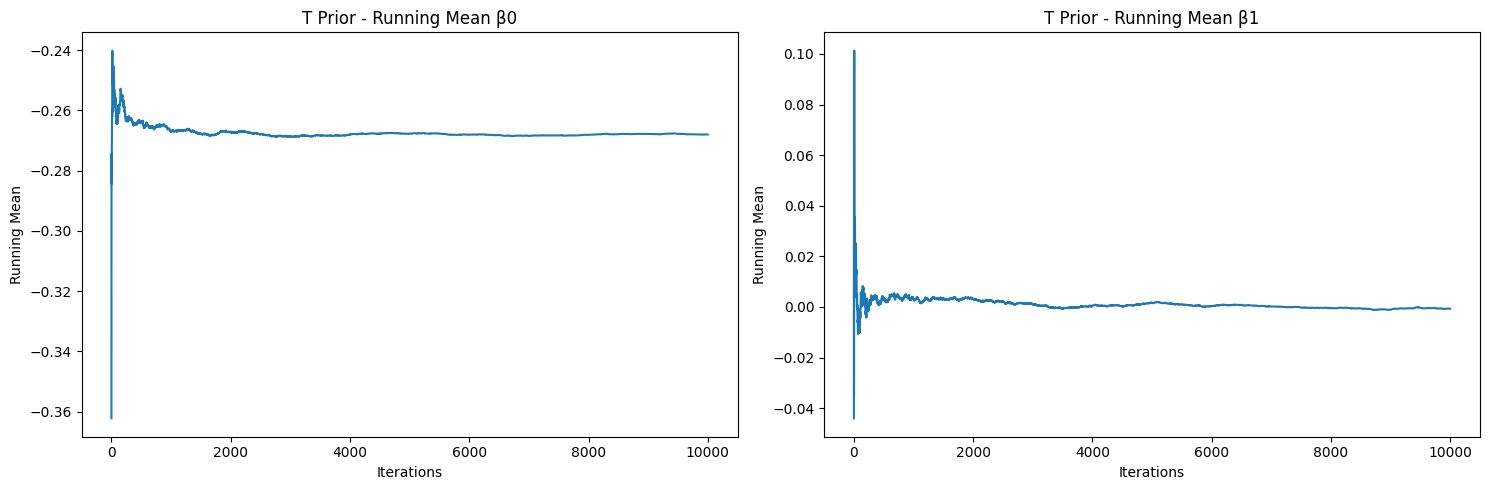

Output()

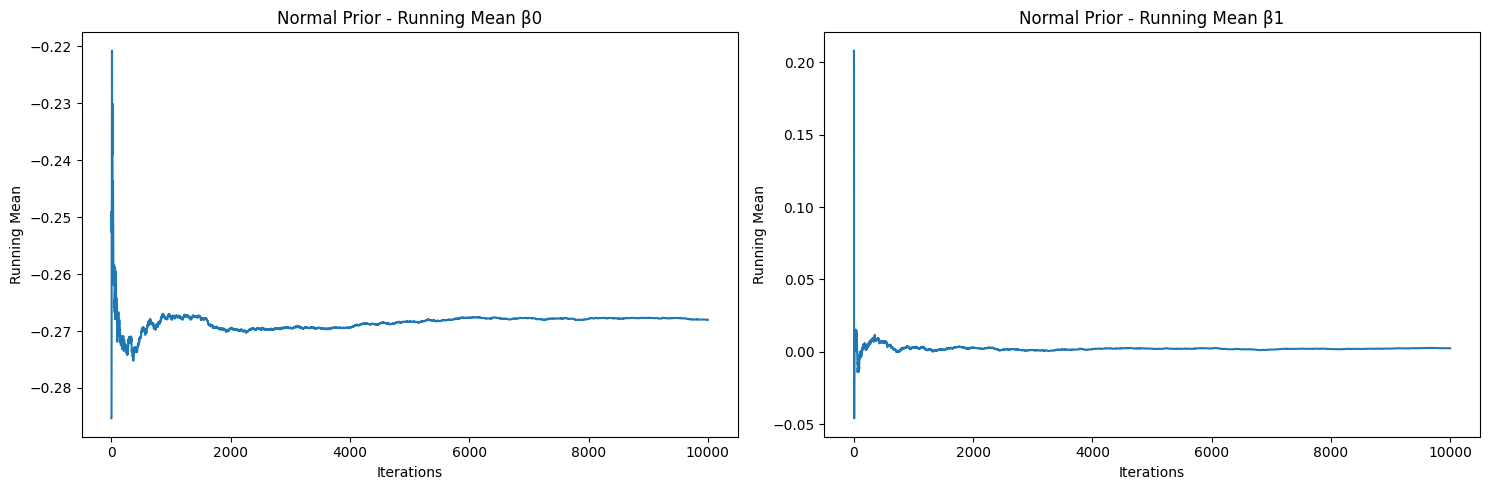

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import scipy.stats as stats

def generate_simulated_dataset(n=30, p=2):
    """
    Generate a simulated dataset with complete separation
    """
    X1 = np.ones((n, 1))  # Intercept vector
    X2 = np.random.uniform(-1, 1, (n, 1))

    # Create a dataset with complete separation
    y = (X2 > 0).astype(int)

    return X1, X2, y

def run_bayesian_inference(X1, X2, y, prior_type='cauchy'):
    """
    Run Bayesian inference with different prior distributions
    """
    with pm.Model() as model:
        # Define priors based on the type
        if prior_type == 'cauchy':
            beta0 = pm.Cauchy('beta0', alpha=0, beta=1)
            beta1 = pm.Cauchy('beta1', alpha=0, beta=1)
        elif prior_type == 't':
            beta0 = pm.StudentT('beta0', nu=4, mu=0, sigma=1)
            beta1 = pm.StudentT('beta1', nu=4, mu=0, sigma=1)
        else:  # normal prior
            beta0 = pm.Normal('beta0', mu=0, sigma=1)
            beta1 = pm.Normal('beta1', mu=0, sigma=1)

        # Linear model
        mu = beta0 + beta1 * X2.flatten()

        # Likelihood
        likelihood = pm.Bernoulli('likelihood', logit_p=mu, observed=y)

        # Sample from posterior
        trace = pm.sample(5000, tune=1000, return_inferencedata=True)

    return trace

def plot_running_means(trace, prior_type):
    """
    Plot running means for beta0 and beta1
    """
    plt.figure(figsize=(15, 5))

    # Plot for beta0
    plt.subplot(1, 2, 1)
    beta0_samples = trace.posterior['beta0'].values.flatten()
    running_means_beta0 = np.cumsum(beta0_samples) / np.arange(1, len(beta0_samples) + 1)
    plt.plot(running_means_beta0)
    plt.title(f'{prior_type.capitalize()} Prior - Running Mean β0')
    plt.xlabel('Iterations')
    plt.ylabel('Running Mean')

    # Plot for beta1
    plt.subplot(1, 2, 2)
    beta1_samples = trace.posterior['beta1'].values.flatten()
    running_means_beta1 = np.cumsum(beta1_samples) / np.arange(1, len(beta1_samples) + 1)
    plt.plot(running_means_beta1)
    plt.title(f'{prior_type.capitalize()} Prior - Running Mean β1')
    plt.xlabel('Iterations')
    plt.ylabel('Running Mean')

    plt.tight_layout()
    plt.show()

def plot_scatter(X1, X2, y):
    """
    Create scatter plot demonstrating complete separation
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(X2[y == 0], y[y == 0], color='blue', label='Class 0')
    plt.scatter(X2[y == 1], y[y == 1], color='red', label='Class 1')
    plt.title('Scatter Plot with Complete Separation')
    plt.xlabel('X2')
    plt.ylabel('Y')
    plt.axvline(x=-0.3, color='black', linestyle='--')
    plt.legend()
    plt.show()

# Set random seed for reproducibility
np.random.seed(42)

# Generate dataset
X1, X2, y = generate_simulated_dataset()

# Plot scatter
plot_scatter(X1, X2, y)

# Run inference with different priors
prior_types = ['cauchy', 't', 'normal']
for prior_type in prior_types:
    trace = run_bayesian_inference(X1, X2, y, prior_type)
    plot_running_means(trace, prior_type)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)  # For reproducibility
n = 30
p = 2

# X1 is a vector of ones (intercept)
X1 = np.ones(n)

# Generate X2 for complete separation at X2 = -0.3
X2 = np.concatenate([np.random.uniform(-1, -0.3, 15), np.random.uniform(-0.3, 1, 15)])
y = np.where(X2 < -0.3, 0, 1)

# Introduce overlap at X2 = 0
X2[13:15] = np.random.uniform(-0.1, 0.1, 2)  # Move some points near 0
X2[28:30] = np.random.uniform(-0.1, 0.1, 2)
y[13:15] = 0  # Ensure some y=0 near X2=0
y[28:30] = 1  # Ensure some y=1 near X2=0

# Create the design matrix
X = np.column_stack((X1, X2))

# Scatter plot (Figure 5)
plt.figure()
plt.scatter(X2, y, marker='x')
plt.axvline(x=-0.3, color='black', linewidth=2)  # Solid line at -0.3
plt.axvline(x=0, color='blue', linestyle='--', linewidth=2)  # Dashed line at 0
plt.xlabel('X2')
plt.ylabel('y')
plt.title('Scatter Plot of y vs X2')
plt.savefig('figure5.png')
plt.close()

In [5]:
import scipy.stats as stats

# Number of iterations
n_iter = 50000

# Log-likelihood function
def log_likelihood(beta, X, y):
    eta = X @ beta
    p = 1 / (1 + np.exp(-eta))
    return np.sum(stats.binom.logpmf(y, 1, p))

# Gibbs sampler with Metropolis-Hastings
def gibbs_sampler(X, y, prior, n_iter, proposal_sd=0.5):
    p = X.shape[1]
    beta_samples = np.zeros((n_iter, p))
    beta = np.zeros(p)  # Initial value

    for iter in range(n_iter):
        for j in range(p):
            beta_current = beta.copy()

            # Propose new beta_j
            beta_proposed = beta.copy()
            beta_proposed[j] = beta[j] + np.random.normal(0, proposal_sd)

            # Log-likelihood
            ll_current = log_likelihood(beta_current, X, y)
            ll_proposed = log_likelihood(beta_proposed, X, y)

            # Log-prior
            if prior == "cauchy":
                lp_current = np.sum(stats.cauchy.logpdf(beta_current, 0, 1))
                lp_proposed = np.sum(stats.cauchy.logpdf(beta_proposed, 0, 1))
            elif prior == "t7":
                lp_current = np.sum(stats.t.logpdf(beta_current, df=7))
                lp_proposed = np.sum(stats.t.logpdf(beta_proposed, df=7))
            else:  # normal
                lp_current = np.sum(stats.norm.logpdf(beta_current, 0, 1))
                lp_proposed = np.sum(stats.norm.logpdf(beta_proposed, 0, 1))

            # Log-posterior ratio
            log_ratio = (ll_proposed + lp_proposed) - (ll_current + lp_current)

            # Accept or reject
            if np.log(np.random.uniform()) < log_ratio:
                beta[j] = beta_proposed[j]

        beta_samples[iter, :] = beta
    return beta_samples

# Run Gibbs sampler for each prior
beta_cauchy = gibbs_sampler(X, y, "cauchy", n_iter)
beta_t7 = gibbs_sampler(X, y, "t7", n_iter)
beta_normal = gibbs_sampler(X, y, "normal", n_iter)

# Compute running means
def running_mean(x):
    return np.cumsum(x) / np.arange(1, len(x) + 1)

# Plot running means (Figure 4)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Beta 1
axes[0, 0].plot(running_mean(beta_cauchy[:, 0]))
axes[0, 0].set_title("Cauchy prior")
axes[0, 0].set_xlabel("Iterations")
axes[0, 0].set_ylabel("Beta 1")

axes[0, 1].plot(running_mean(beta_t7[:, 0]))
axes[0, 1].set_title("t7 prior")
axes[0, 1].set_xlabel("Iterations")
axes[0, 1].set_ylabel("Beta 1")

axes[0, 2].plot(running_mean(beta_normal[:, 0]))
axes[0, 2].set_title("normal prior")
axes[0, 2].set_xlabel("Iterations")
axes[0, 2].set_ylabel("Beta 1")

# Beta 2
axes[1, 0].plot(running_mean(beta_cauchy[:, 1]))
axes[1, 0].set_title("Cauchy prior")
axes[1, 0].set_xlabel("Iterations")
axes[1, 0].set_ylabel("Beta 2")

axes[1, 1].plot(running_mean(beta_t7[:, 1]))
axes[1, 1].set_title("t7 prior")
axes[1, 1].set_xlabel("Iterations")
axes[1, 1].set_ylabel("Beta 2")

axes[1, 2].plot(running_mean(beta_normal[:, 1]))
axes[1, 2].set_title("normal prior")
axes[1, 2].set_xlabel("Iterations")
axes[1, 2].set_ylabel("Beta 2")

plt.tight_layout()
plt.savefig("figure4.png")
plt.close()